In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats
import scipy.io
from matplotlib import cm
from scipy.optimize import minimize
from scipy.interpolate import griddata
plt.rcParams['font.size'] = 14
plt.rcParams['axes.spines.right'] = False
plt.rcParams['ytick.right'] = False
plt.rcParams['axes.spines.top'] = False
plt.rcParams['xtick.top'] = False

### Low-rank receptive field models
In part 1 and 2, we introduced a generalized linear model using Poisson regression together with a soft-thresholding nonlinearity $(f)$. We saw that the parameters $\mathbf{w}$ of the model could be found by minimizing the negative log-likelihood $(nll)$, and that we could incorporate prior knowledge through a regularization term. Here, we will further incorporate the nuclear norm regularization term introduced in Part 3, as this provides a way for estimating low-rank spatial-temporal receptive field (RF) models.

The spatial-temporal RF is usually thought of as a two-or three-dimensional matrix: one time dimension and one or two spatial dimensions. However, it is often not possible to estimate the full spatial-temporal RF, as it might require more data that what is available. One common approximation is then to assume space-time separability, which implies that the full RF matrix can be constructed as an outer product of a spatial and a temporal filter. This approximation usually works well for retinal ganglion cells, especially if they are not motion sensitive, but it might also approximate away interesting details. This is were nuclear norm regularization steps into the picture, as it comes with a parameter $\lambda$ that can be used to adjust the rank of the estimated RF. A high value of $\lambda$ results in a rank 1 RF, that is a time-space separable RF, whereas slightly lower values will provide low-rank RFs with additional structure.

### Methods
Following part 1 and 2, we define our smooth function $g$ as: 

\begin{align}
 g(\mathbf{w}) &= \sum_i^N f(z_i) - y_i\log(f(z_i)), \\
 f(z_i) &= 
 \begin{cases}
  \exp(z_i),& \text{if  } z_i \leq 0,\\
  z_i + 1,& \text{if  } z_i > 0,\\
 \end{cases} \\
 z_i &= \mathbf{w}^T\mathbf{x}_i,
\end{align}

where $\mathbf{w}$ and $\mathbf{x}_i$ represent the vectorized RF and the vectorized sample matrix, respectively. The sample matrix $\mathbf{X}_i$ is created from the spatial stimulus $\mathbf{s}_i$ at the current and preceding time points as: 

$$
\mathbf{X}_i = \begin{bmatrix}
    s_{i, 1} & s_{i, 2} & s_{i, 3} & \dots  & s_{i, P} \\
    s_{i-1, 1} & s_{i-1, 2} & s_{i-1, 3} & \dots  & s_{i-1, P} \\
    \vdots & \vdots & \vdots & \ddots & \vdots \\
    s_{i-T-1, 1} & s_{i-T-1, 2} & s_{i-T-1, 3} & \dots  & s_{i-T-1, P}
\end{bmatrix}\in\mathbb{R}^{T\times P}.
$$

The sample matrix $\mathbf{X}_i$ as well as the RF ($\mathbf{W}$) thus have one time dimension and one spatial dimension. Following part 3, we thus define our regularization term ($h$) as:

$$
h(W)=\lambda||W||_{tr},
$$

and the full objective function as:

$$
\mathrm{ObjFun}(\mathbf{w}) = g(\mathbf{w}) + h(\mathbf{w}).
$$

The derivative of $g$ is (see part 1):

\begin{align}
 \nabla g &= \sum_i^N \frac{\partial f(z_i) - y_i\log(f(z_i))}{\partial \mathbf{w}}, \\
 \frac{\partial f(z_i) - y_i\log(f(z_i))}{\partial \mathbf{w}} &= 
 \begin{cases}
  (\exp(z_i) - y_i)\mathbf{x}_i,& \text{if  } z_i \leq 0\\
  \left( 1-\frac{y_i}{z_i+1} \right) \mathbf{x}_i,& \text{if  } z_i > 0\\
 \end{cases},
\end{align}

whereas the proximal operator for $h$ is (see part 3):
\begin{align}
 \operatorname{prox}_{\eta\lambda}(B) &= S_{\eta \lambda}(B), \\
 S_{\eta \lambda} &= U\Sigma_{\eta \lambda} V^T,
\end{align}

with $(\Sigma_{\eta \lambda})_{ii}=\operatorname{max}\{\Sigma_{ii}-\eta \lambda,0\}$ and $U \Sigma V^T$ the singular value decomposition of $B$.

In [2]:
def vectorToMatrix(w, wShape):
    return w[1:].reshape(wShape[0], wShape[1])

def matrixToVector(W, w0):
    w = np.empty(W.size+1)
    w[0] = w0
    w[1:] = W.ravel()
    return w

def invLinkFun(X, w):
    z = np.dot(X, w)
    mu = np.zeros(z.shape)
    mu[z<0] = np.exp(z[z<0])
    mu[z>=0] = z[z>=0] + 1
    mu[mu==0] = 1e-10 # Protection against log(0)
    return mu

def gFunDer(X, y, w):
    z = np.dot(X, w)
    der = np.dot(np.exp(z[z<0])-y[z<0], X[z<0, :])
    der += np.dot(1-y[z>=0]/(z[z>=0]+1), X[z>=0, :])
    return der

def gFun(X, y, w):
    return np.sum(invLinkFun(X, w) - y*np.log(invLinkFun(X, w)))

def hFun(w, regLambda, wShape):
    W = vectorToMatrix(w, wShape)
    U, Sigma, VT = np.linalg.svd(W, full_matrices=False)
    return regLambda*np.linalg.norm(Sigma, 1)

def negLogLikFun(X, y, w, reg_lambda): 
    return gFun(X, y, w) + hFun(w, reg_lambda)

def matrixSoftThresholdingFun(W, th):
    U, Sigma, VT = np.linalg.svd(W, full_matrices=False)
    Sigma = Sigma - th
    Sigma[Sigma<0] = 0
    return np.dot(U * Sigma, VT)

def prox(w, th, wShape):
    WOld = vectorToMatrix(w, wShape)
    WNew = matrixSoftThresholdingFun(WOld, th)
    return matrixToVector(WNew, w[0])

# Proximal gradient with backtracking and accerlation
def minimizeObjFun(X, y, w0, wShape, regLambda): 
    
    i = 2
    eta = 1
    beta = 0.8
    epsilon = 1e-5
    wNew = np.copy(w0)
    wOld = np.copy(w0)
    wTmp = np.copy(w0)
    
    objFunVals = []
    objFunVals.append(gFun(X, y, wNew) + hFun(wNew, regLambda, wShape))
    
    converged = False
    while not converged:
        gradTmp = gFunDer(X, y, wTmp)
        gTmp = gFun(X, y, wTmp)
        # Backtracking loop
        while True:
            wNew = prox(wTmp - eta*gradTmp, regLambda*eta, wShape)
            diff = wNew - wTmp
            if gFun(X, y, wNew) > gTmp + np.sum(np.multiply(gradTmp, diff)) + np.sum(diff**2)/(2*eta):
                eta *= beta
            else:
                break
        objFunVals.append(gFun(X, y, wNew) + hFun(wNew, regLambda, wShape))
        wTmp = wNew + (i-2)/(i-1)*(wNew-wOld)
        wOld = wNew
        i += 1
        
        # Converge check, mean over previous iterations due to Nesterow ripples
        if len(objFunVals) > 12: 
            if (np.mean(objFunVals[-12:-2]) - objFunVals[-1]) / objFunVals[-1] < epsilon: 
                converged = True    
            if i > 300:
                converged = True
        
        
    return wNew, np.array(objFunVals)

### Estimation of a low-rank RF from real data
Load example data and create $\mathbf{X}$ and $\mathbf{y}$ based on the wanted time duration of the RF.

In [4]:
# Load real example data
rawData = scipy.io.loadmat('data/20181211Dcc3SpatialRF.mat')
stimulus = rawData['data']['SpatialRFData'][0][0][0,0]['X']
spikeCounts = rawData['data']['SpatialRFData'][0][0][0,0]['Y']
stimPositions = rawData['data']['SpatialRFData'][0][0][0,0]['FlashPositions']
binWidth = rawData['data']['SpatialRFData'][0][0][0,0]['BinWidth']

# Define the the shape of the RF
nLags = 30
rfShape = [nLags, stimPositions.shape[0]]
nParams = rfShape[0]*rfShape[1]

# Create X and y data
y = np.copy(spikeCounts[nLags-1:].ravel()) # ignore the first bins that lack a whole stimulus matrix
# Create X by stacking time shifted stimulus matrices horizontally
X = np.ones((y.size, nParams+1))
for i in range(nLags-1):
    startIdx = i*stimPositions.shape[0]+1
    endIdx = (i+1)*stimPositions.shape[0]+1
    X[:,startIdx:endIdx] = stimulus[i:-nLags+i+1, :]
startIdx = (nLags-1)*stimPositions.shape[0]+1
X[:,startIdx:] = stimulus[nLags-1:, :]

### Example analyses using the low-rank RF
We first set $\lambda$ to be just high enough to ensure that we only get one non-zero singular value. This ensures that we end up with a time-space separable RF.

Rank(B): 1


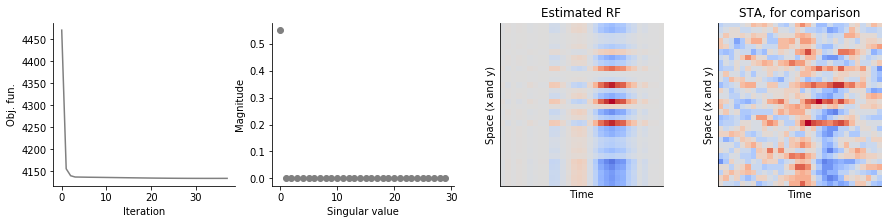

In [5]:
# Run proximal gradient to find the RF parameters
w0 = np.zeros(X.shape[1])
wRF1, objFunVals = minimizeObjFun(X, y, w0, rfShape, 50)
# Transform the vector into a time-space separable spatial-temporal RF
WRF1 = vectorToMatrix(wRF1, rfShape)
U,Sigma,VT = np.linalg.svd(WRF1, full_matrices=False)
print('Rank(B):', np.sum(Sigma > 1e-10))

# Computing the spike triggered average for comparison
wSTA = np.dot(X.T - X[:, 1:].mean(), y)
WSTA = vectorToMatrix(wSTA, rfShape)

# Plotting
fig = plt.figure(figsize=(15, 3))
# Objective function
ax = fig.add_subplot(1, 4, 1)
ax.plot(range(objFunVals.size), objFunVals, c=[0.5, 0.5, 0.5])
ax.set_xlabel('Iteration')
ax.set_ylabel('Obj. fun.')
# Singular values
ax = fig.add_subplot(1, 4, 2)
ax.plot(range(Sigma.size), Sigma, 'o', ms=6, c=[0.5, 0.5, 0.5])
ax.set_xlabel('Singular value')
ax.set_ylabel('Magnitude')
# W
ax = fig.add_subplot(1, 4, 3)
ax.imshow(WRF1.T, cmap=cm.coolwarm, clim=[-np.max(np.abs(WRF1)), np.max(np.abs(WRF1))])
ax.set_title('Estimated RF')
ax.set_xlabel('Time')
ax.set_ylabel('Space (x and y)')
ax.set_xticks([])
ax.set_yticks([]);
# W
ax = fig.add_subplot(1, 4, 4)
ax.imshow(WSTA.T, cmap=cm.coolwarm, clim=[-np.max(np.abs(WSTA)), np.max(np.abs(WSTA))])
ax.set_title('STA, for comparison')
ax.set_xlabel('Time')
ax.set_ylabel('Space (x and y)')
ax.set_xticks([])
ax.set_yticks([]);

The RF above is not ideal for conveying an understandable description of the cells stimulus-response mapping: the reason being that both spatial dimensions have been combined along the same axis. However, as the RF is a rank one matrix, we can plot the spatial and the temporal filters separately. Next, we therefore analyze both separately.

RF center: -12.5, -5.4
sigma: 54.2


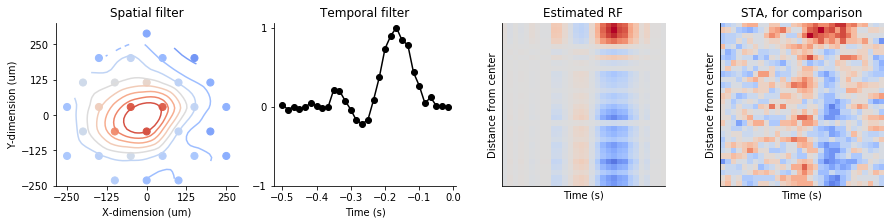

In [8]:
# Make sure the spatial RF center is positive
maxIdx = np.argmax(np.abs(VT[0, :]))
if VT[0, maxIdx] < 0:
    U[:, 0] *= -1
    VT[0, :] *= -1

# Cubic interpolation of the spatial RF onto a grid, for visualization purposes only
grid_points = np.linspace(-250, 250, 41)
grid_x, grid_y = np.meshgrid(grid_points, grid_points)
grid_z = griddata(stimPositions, VT[0, :], (grid_x, grid_y), method='cubic')
grid_z = np.ma.masked_where(np.isnan(grid_z), grid_z)
cLim = np.max(np.abs(grid_z))
levels = np.linspace(-cLim, cLim, 11)

# Find the RF center by fitting a symmetric Gaussian to the spatial RF
gaussianFun = lambda amplitude, center, sigma, positions: amplitude*np.exp(-np.sum((positions-center)**2 / (2*sigma**2), axis=1))
mseFun = lambda e: np.dot(e, e) / (2*e.size)
def gaussianObjFun(params, positions, heights):
    predictions = gaussianFun(params[0], params[1:3], params[-1], positions)
    errors = heights - predictions
    mes = mseFun(errors)
    return mes
params = minimize(gaussianObjFun, np.array([1, 0, 0, 100]), (stimPositions, VT[0, :]))
print('RF center: {:3.1f}, {:3.1f}\nsigma: {:3.1f}'.format(params.x[1], params.x[2], params.x[3]))

# Sort the all spatial positions based on their distance to the RF center
distance = stimPositions-params.x[1:3]
radius = np.sqrt(np.sum(distance**2, axis=1))
sortOrder = np.argsort(radius)

fig = plt.figure(figsize=(15, 3))
# Spatial filter
ax = fig.add_subplot(1, 4, 1)
ax.contour(grid_x, grid_y, grid_z, levels, cmap=cm.coolwarm, vmin=-cLim, vmax=cLim)
plt.scatter(stimPositions[:,0],stimPositions[:,1], 50, VT[0, :], cmap=cm.coolwarm, vmin=-cLim, vmax=cLim)
ax.set_title('Spatial filter')
ax.set_xticks([-250, -125, 0, 125, 250])
ax.set_yticks([-250, -125, 0, 125, 250])
ax.set_xlabel('X-dimension (um)')
ax.set_ylabel('Y-dimension (um)')
# Temporal filter
dt = 1./60
time = np.arange(-nLags*dt, 0, dt)
ax = fig.add_subplot(1, 4, 2)
ax.plot(time, U[:, 0]/np.max(np.abs(U[:, 0])), 'ko-')
ax.set_title('Temporal filter')
ax.set_yticks([-1, 0, 1]);
ax.set_xlabel('Time (s)')
# W, sorted
ax = fig.add_subplot(1, 4, 3)
ax.imshow(WRF1[:, sortOrder].T, cmap=cm.coolwarm, clim=[-np.max(np.abs(WRF1)), np.max(np.abs(WRF1))])
ax.set_title('Estimated RF')
ax.set_xticks([])
ax.set_yticks([]);
ax.set_xlabel('Time (s)')
ax.set_ylabel('Distance from center');
# STA, sorted
ax = fig.add_subplot(1, 4, 4)
ax.imshow(WSTA[:, sortOrder].T, cmap=cm.coolwarm, clim=[-np.max(np.abs(WSTA)), np.max(np.abs(WSTA))])
ax.set_title('STA, for comparison')
ax.set_xticks([])
ax.set_yticks([]);
ax.set_xlabel('Time (s)')
ax.set_ylabel('Distance from center');

Next, we estimate a new low-rank RF model to with a $\lambda$ value just high enough to get two non-zero singular values. The difference between the rank 1 and the rank 2 RF should then show the structure that was approximated away when we initially assumed a time-space separable RF.

Rank(B): 2


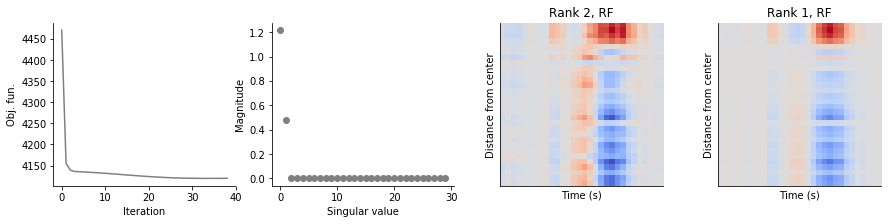

In [9]:
# Run proximal gradient to find the RF parameters
w0 = np.zeros(X.shape[1])
wRF, objFunVals = minimizeObjFun(X, y, w0, rfShape, 35)
# Transform the vector into a time-space separable spatial-temporal RF
WRF = vectorToMatrix(wRF, rfShape)
U,Sigma,VT = np.linalg.svd(WRF, full_matrices=False)
print('Rank(B):', np.sum(Sigma > 1e-10))

# Plotting
fig = plt.figure(figsize=(15, 3))
# Objective function
ax = fig.add_subplot(1, 4, 1)
ax.plot(range(objFunVals.size), objFunVals, c=[0.5, 0.5, 0.5])
ax.set_xlabel('Iteration')
ax.set_ylabel('Obj. fun.')
# Singular values
ax = fig.add_subplot(1, 4, 2)
ax.plot(range(Sigma.size), Sigma, 'o', ms=6, c=[0.5, 0.5, 0.5])
ax.set_xlabel('Singular value')
ax.set_ylabel('Magnitude')
# W, new
ax = fig.add_subplot(1, 4, 3)
ax.imshow(WRF[:, sortOrder].T, cmap=cm.coolwarm, clim=[-np.max(np.abs(WRF)), np.max(np.abs(WRF))])
ax.set_title('Rank {:1d}, RF'.format(np.sum(Sigma > 1e-10)))
ax.set_xticks([])
ax.set_yticks([])
ax.set_xlabel('Time (s)')
ax.set_ylabel('Distance from center');
# W, rank 1
ax = fig.add_subplot(1, 4, 4)
ax.imshow(WRF1[:, sortOrder].T, cmap=cm.coolwarm, clim=[-np.max(np.abs(WRF1)), np.max(np.abs(WRF1))])
ax.set_title('Rank 1, RF')
ax.set_xticks([])
ax.set_yticks([])
ax.set_xlabel('Time (s)')
ax.set_ylabel('Distance from center');